In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i78pjirl because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


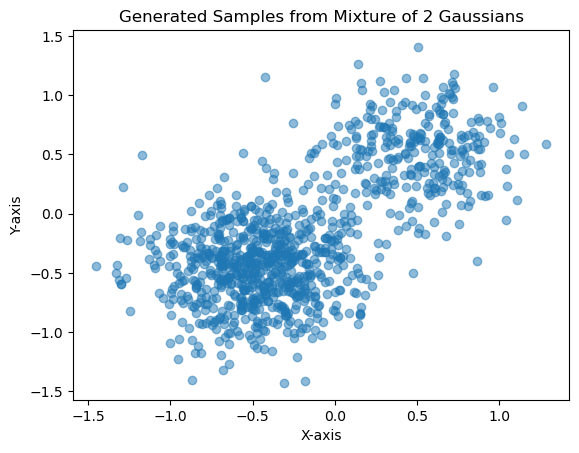

In [2]:
# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-.5, -.5])
covariance1 = np.array([[.1, 0.], [0., .1]])
precision1 = inv(covariance1)
weight1 = .7

mean2 = np.array([.5, .5])
covariance2 = np.array([[.1, 0.], [0., .1]])
precision2 = inv(covariance2)
weight2 = .3

# Generate synthetic data
np.random.seed(42)
num_samples = 1000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]

generated_samples = generate_samples(num_samples, means, covariances, weights)

# Plot the generated samples
import matplotlib.pyplot as plt

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [4]:
# problem dimension
d = 2

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[d, d], [d], [d, d], [d], [d, d], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
eps = .001
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1.3/np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2, W3, b3 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W2, h) + b2)
    
    # output
    z = jnp.einsum('ij,...j->...i', W3, h) + b3
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

@jit 
def inv_nn(z, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2, W3, b3 = reshape(lmbda)
    
    # hidden layer
    h = jnp.einsum('ij,...j->...i', inv(W3), z - b3)
    
    # input 
    h = jnp.einsum('ij,...j->...i', inv(W2), jnp.arctanh(h) - b2)
    
    # input 
    y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

    return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [5]:
y = np.random.randn(1, d)
y

array([[-2.05035746,  0.73918049]])

In [6]:
inv_nn(nn(y, lmbda), lmbda)

Array([[-2.0503256 ,  0.73913795]], dtype=float32)

In [7]:
# make sure NN is flexible enough to capture true posterior

# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    l1 = weight1*jnp.einsum('i,ij,j', mean1-zi, precision1, mean1-zi) / 2.
    l2 = weight2*jnp.einsum('i,ij,j', mean2-zi, precision2, mean2-zi) / 2.
    return l1 + l2  
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [14]:
# callback
def callback(x):
    print("KL: {:.3f}".format(kl(x, n_sample=100)))

res = minimize(fun=kl,
               jac=grad_kl,
               x0=lmbda,
               method='BFGS', 
               callback=callback)

lmbda = res.x

KL: 5.615
KL: 5.725
KL: 5.675
KL: 5.691
KL: 5.741
KL: 5.661
KL: 5.423
KL: 5.558
KL: 5.427
KL: 5.324
KL: 5.209
KL: 5.427
KL: 5.404
KL: 5.432


In [9]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=500, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=100)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [17]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 5.312
KL 5.541
KL 5.736
KL 5.293
KL 5.379
KL 5.355
KL 5.585
KL 5.546
KL 5.362
KL 5.300
KL 5.435
KL 5.308
KL 5.528
KL 5.546
KL 5.336
KL 5.371
KL 5.357
KL 5.362
KL 5.294
KL 5.285
KL 5.502
KL 5.435
KL 5.581
KL 5.352
KL 5.435
KL 5.435
KL 5.576
KL 5.256
KL 5.340
KL 5.360
KL 5.446
KL 5.537
KL 5.435
KL 5.526
KL 5.368
KL 5.434
KL 5.277
KL 5.416
KL 5.455
KL 5.343
KL 5.303
KL 5.429
KL 5.474
KL 5.416
KL 5.387
KL 5.437
KL 5.424
KL 5.332
KL 5.446
KL 5.386


In [18]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

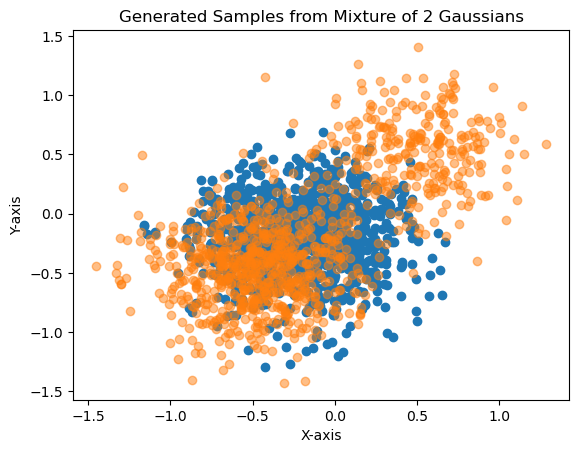

In [19]:
plt.scatter(z[:, 0], z[:, 1])
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()